#Лабораторная работа №2
####Емельянов Виталий, 293 группа

##1. Вспомогательные функции и загрузка датасета

In [692]:
import pandas
import numpy
import sklearn
import urllib2
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt


fpr = {}
tpr = {}
auc_roc = {}
precision = {}
recall = {}
avg_precision = {}


def init_data():
    
    SPAMBASE_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
    SPAMBASE_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

    feature_names = [
        line.strip().split(':')[0] 
        for line in urllib2.urlopen(SPAMBASE_NAMES_URL).readlines()[33:]
    ]
    spam_data = pd.read_csv(SPAMBASE_DATA_URL, header=None, names=(feature_names + ['spam']))

    X, y = spam_data.ix[:, :-1].values, spam_data.ix[:, -1].values
    
    return (spam_data, X, y)


def print_statistics(y_test, y_predicted):
    
    [[TP, FN], [FP, TN]] = sklearn.metrics.confusion_matrix(y_test, y_predicted)
    accuracy = float(TP + TN) / (TP + TN + FP + FN)
    precision = float(TP) / (TP + FP)
    recall = float(TP) / (TP + FN)
    f1 = 2*float(TP) / (2*TP + FP + FN)    
    
    print "Accuracy = ", accuracy
    print "Precision = ", precision
    print "Recall = ", recall
    print "F1 = ", f1
    
    
def normalize_data(data):
    
    normalized_data = deepcopy(data)
    
    for column in data.columns:
        normalized_data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
        
    normalized_X, normalized_y = normalized_data.ix[:, :-1].values, normalized_data.ix[:, -1].values
    
    return (normalized_data, normalized_X, normalized_y)


spam_data, X, y = init_data()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


###Количество писем в датасете

In [693]:
len(spam_data)

4601

Ответ: 4601 письмо

###Количество плохих писем

In [694]:
spam_data['spam'].sum()

1813

In [695]:
spam_data['spam'].mean() * 100

39.404477287546186

1813 "плохих" писем, что есть 39% от общего числа

###Характерные признаки в наборе

In [696]:
for column in spam_data.columns:
    print column, ' ',

word_freq_make   word_freq_address   word_freq_all   word_freq_3d   word_freq_our   word_freq_over   word_freq_remove   word_freq_internet   word_freq_order   word_freq_mail   word_freq_receive   word_freq_will   word_freq_people   word_freq_report   word_freq_addresses   word_freq_free   word_freq_business   word_freq_email   word_freq_you   word_freq_credit   word_freq_your   word_freq_font   word_freq_000   word_freq_money   word_freq_hp   word_freq_hpl   word_freq_george   word_freq_650   word_freq_lab   word_freq_labs   word_freq_telnet   word_freq_857   word_freq_data   word_freq_415   word_freq_85   word_freq_technology   word_freq_1999   word_freq_parts   word_freq_pm   word_freq_direct   word_freq_cs   word_freq_meeting   word_freq_original   word_freq_project   word_freq_re   word_freq_edu   word_freq_table   word_freq_conference   char_freq_;   char_freq_(   char_freq_[   char_freq_!   char_freq_$   char_freq_#   capital_run_length_average   capital_run_length_longest   capi

Характерными признаками являются частоты слов, которые зачастую  встречаются в спаме. Это слова: money, receive, all, credit и т.п.<br>
Частоты символов $, #, ! ...<br>


## 2. Обучение классификатора и оценка его качества

###Решающее дерево

Разбиваем на обучающую и тестовую выборки

In [697]:
train = spam_data.ix[:3000, :]
test = spam_data.ix[3000:, :]

Обучаем решающее дерево на train выборке

In [698]:
from sklearn.tree import DecisionTreeClassifier


X_train = train.ix[:, :train.shape[1]-1]
y_train = train['spam']

cls = DecisionTreeClassifier(criterion='gini', max_depth=7).fit(X_train, y_train)

X_test = test.ix[:, :test.shape[1]-1]
y_test = test['spam']

y_predicted = cls.predict(X_test)

print_statistics(y_test, y_predicted)

Accuracy =  0.772017489069
Precision =  1.0
Recall =  0.772017489069
F1 =  0.871342967924


Повторим, случайно перемешав объекты исходной выборки перед разбиением

In [699]:
from sklearn.cross_validation import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3000)

cls = DecisionTreeClassifier(criterion='gini', max_depth=7).fit(X_train, y_train)
y_predicted = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)

classifier_name = 'dtree'
fpr[classifier_name], tpr[classifier_name], thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc[classifier_name] = auc(fpr[classifier_name], tpr[classifier_name])
precision[classifier_name], recall[classifier_name], _ = precision_recall_curve(y_test, y_probs[:, 1])
avg_precision[classifier_name] = average_precision_score(y_test, y_probs[:, 1])

print_statistics(y_test, y_predicted)

Accuracy =  0.909431605247
Precision =  0.913811007269
Recall =  0.934182590234
F1 =  0.923884514436


Видно, что качество классификации заметно возросло.

####Наиболее важные признаки

In [700]:
importances = cls.feature_importances_

for i in range(len(importances)):
    if importances[i]> 0.03:
        print spam_data.columns[i], importances[i]

word_freq_remove 0.10952872613
word_freq_free 0.0534041620616
word_freq_your 0.0334408652524
word_freq_money 0.0442972482443
word_freq_hp 0.0427529969063
char_freq_! 0.41853409844
capital_run_length_average 0.132427325738


Оказывается, что наиболее важными признаками оказались частоты слов "remove", "hp", а также частоты символов '!' и '$'

###Константная модель

Лучшая константная модель дает accuracy около 61% процента.<br>
Это очевидно, ведь если мы все время будем отвечать 0, то ошибемся лишь в ~39% случаев, ведь у нас всего 39% писем, помеченных как спам.

###KNN

In [701]:
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3000)

cls = KNeighborsClassifier(n_neighbors=10, metric='minkowski').fit(X_train, y_train)
y_predicted = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)

classifier_name = 'knn'
fpr[classifier_name], tpr[classifier_name], thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc[classifier_name] = auc(fpr[classifier_name], tpr[classifier_name])
precision[classifier_name], recall[classifier_name], _ = precision_recall_curve(y_test, y_probs[:, 1])
avg_precision[classifier_name] = average_precision_score(y_test, y_probs[:, 1])

print_statistics(y_test, y_predicted)

Accuracy =  0.792629606496
Precision =  0.802303262956
Recall =  0.869022869023
F1 =  0.834331337325


###Масштабирование данных

####KNN

In [702]:
normalized_data, normalized_X, normalized_y = normalize_data(spam_data)
   
X_train, X_test, y_train, y_test = train_test_split(normalized_X, normalized_y, train_size=3000)
cls = KNeighborsClassifier(n_neighbors=10, metric='minkowski').fit(X_train, y_train)

y_predicted = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)

classifier_name = 'normalized_knn'
fpr[classifier_name], tpr[classifier_name], thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc[classifier_name] = auc(fpr[classifier_name], tpr[classifier_name])
precision[classifier_name], recall[classifier_name], _ = precision_recall_curve(y_test, y_probs[:, 1])
avg_precision[classifier_name] = average_precision_score(y_test, y_probs[:, 1])

print_statistics(y_test, y_predicted)



Accuracy =  0.888194878201
Precision =  0.878192534381
Recall =  0.942044257113
F1 =  0.908998474835


Видно, что масштабирование заметно повлияло на качество классификации алгоритма KNN.<br>
Это связано с тем, что раннее признак, имевший бОльшие значения, мог повлиять на оценку. Теперь же, все значения элементов столбцов лежат в [0, 1].

####Решающее дерево

In [703]:
normalized_data, normalized_X, normalized_y = normalize_data(spam_data)   
X_train, X_test, y_train, y_test = train_test_split(normalized_X, normalized_y, train_size=3000)

cls = DecisionTreeClassifier(criterion='gini', max_depth=7).fit(X_train, y_train)
y_predicted = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)

classifier_name = 'normalized_dtree'
fpr[classifier_name], tpr[classifier_name], thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc[classifier_name] = auc(fpr[classifier_name], tpr[classifier_name])
precision[classifier_name], recall[classifier_name], _ = precision_recall_curve(y_test, y_probs[:, 1])
avg_precision[classifier_name] = average_precision_score(y_test, y_probs[:, 1])

print_statistics(y_test, y_predicted)

Accuracy =  0.919425359151
Precision =  0.91924227318
Recall =  0.950515463918
F1 =  0.934617334009


Масштабирование не повлияло на качество классификации алгоритма решаюшего дерева, что естественно, так как в каждой  вершине дерева рассматривается только один признак.

##3. Выбор порога классификации


Классификатор имеет AUC-ROC близкий к нулю, если он часто говорит FP.<br>
То есть в тех случаях, когда нужно отнести объект к отрицательному классу, он относит его к положительному.

###ROC-кривая

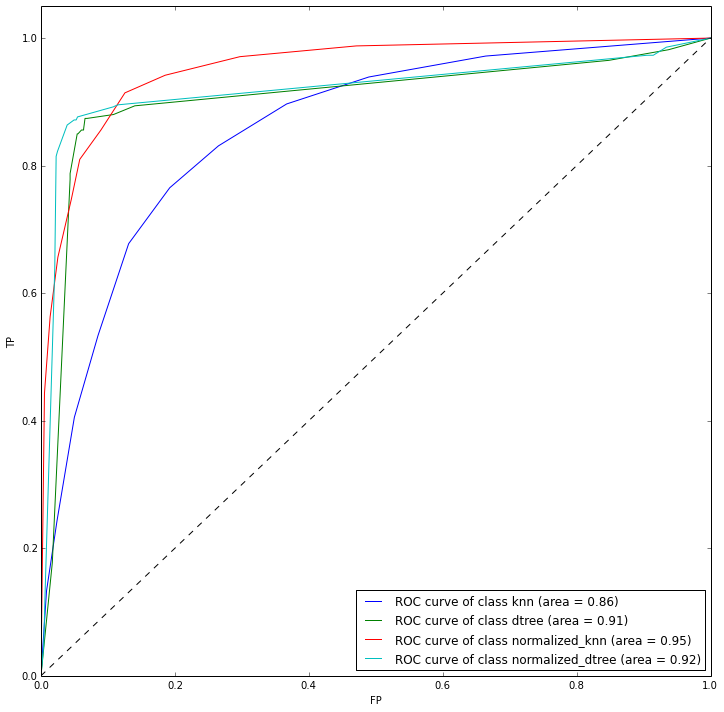

In [704]:
plt.figure(figsize = (12, 12))

for key in fpr.keys():
    plt.plot(fpr[key], tpr[key], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(key, roc_auc[key]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.legend(loc="lower right")
plt.show()

###Precision/Recall кривая

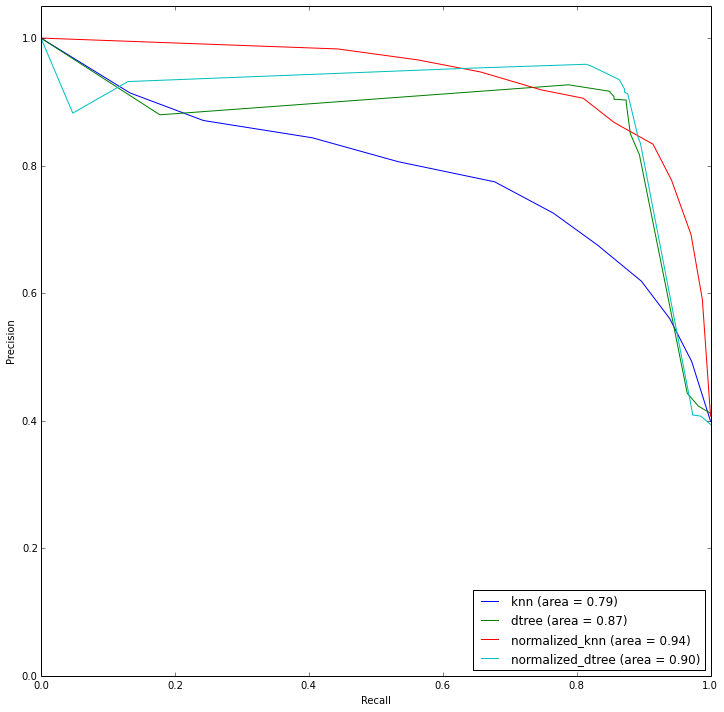

In [705]:
plt.figure(figsize = (12, 12))

for key in precision.keys():    
    plt.plot(recall[key], precision[key],
    label='{0} (area = {1:0.2f})'
    ''.format(key, avg_precision[key]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.show()

##4. Кросс-валидация и подбор параметров

In [706]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_validation import cross_val_score as CVS
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV


normalized_data, normalized_X, normalized_y = normalize_data(spam_data)   
X_train, X_test, y_train, y_test = train_test_split(normalized_X, normalized_y, train_size=3000)

###Оптимальный набор параметров дерева

In [709]:
params = {'max_depth': range(2,12),
          'criterion': ['entropy', 'gini']}
grid_searcher = GridSearchCV(DecisionTreeClassifier(), \
                             params, cv = KFold(n=len(y_train), n_folds=5, shuffle=True, random_state=17), \
                             scoring='roc_auc', n_jobs=3) 
cls = grid_searcher.fit(X_train, y_train)
y_predict = cls.predict(X_test)

print grid_searcher.best_estimator_

print_statistics(y_predict, y_test)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
Accuracy =  0.922548407245
Precision =  0.951295336788
Recall =  0.922613065327
F1 =  0.936734693878


###Оптимальный набор параметров KNN

In [708]:
params = {'n_neighbors': range(3, 10),
          'weights': ['distance', 'uniform']}

grid_searcher = GridSearchCV(KNN(), \
                             params, cv = KFold(n=len(y_train), n_folds=5, shuffle=True, random_state=123), \
                             scoring='roc_auc', n_jobs=3) 


cls = grid_searcher.fit(X_train, y_train)
y_predict = cls.predict(X_test)

print grid_searcher.best_estimator_

print_statistics(y_predict, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=8, p=2, weights='distance')
Accuracy =  0.90755777639
Precision =  0.926424870466
Recall =  0.92070030896
F1 =  0.923553719008


Сравнивая с предыдущими результатами, делаем вывод, что мы нашли оптимальные параметры в пределах сетки.